In [1]:
from softcomputing_packages_bu import *

Copyright 2016, Seok-Jun Bu, Softcomputing Lab. All Rights Reserved.
Importing Soft-computing Packages . . .
	General python-science packages loaded.
	Deep learning toolkit loaded.
	Handcrafted functions loaded:
		sjbu_sample(X, n_sample, shuffle=True/False)
		sjbu_scaler(X, mode='standard/robust/minmax/maxabs', channel='first')
		sjbu_plot_history(model_history, mode='loss', title='Entropy')
		sjbu_confusion_matrix(model_input, feature, label, class_list=['first', 'second'], fig_size=(5,5))
		sjbu_categorical_recall(input_class_idx)
		sjbu_set_font(font_family='Times New Roman', font_size=10)
. . . Done.


In [35]:
import scipy as sp
from scipy.fftpack import fft
from scipy import signal
def emd(x, nIMF = 3, stoplim = .001):
    """Perform empirical mode decomposition to extract 'niMF' components out of the signal 'x'."""
    r = x
    t = np.arange(len(r))
    imfs = np.zeros(nIMF,dtype=object)
    for i in range(nIMF):
        r_t = r
        is_imf = False      
        while is_imf == False:
            # Identify peaks and troughs
            pks = sp.signal.argrelmax(r_t)[0]
            trs = sp.signal.argrelmin(r_t)[0]            
            # Interpolate extrema
            pks_r = r_t[pks]
            fip = sp.interpolate.InterpolatedUnivariateSpline(pks,pks_r,k=3)
            pks_t = fip(t)           
            trs_r = r_t[trs]
            fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,trs_r,k=3)
            trs_t = fitr(t)            
            # Calculate mean
            mean_t = (pks_t + trs_t) / 2
            mean_t = _emd_complim(mean_t, pks, trs)            
            # Assess if this is an IMF (only look in time between peaks and troughs)
            sdk = _emd_comperror(r_t, mean_t, pks, trs)       
            # if not imf, update r_t and is_imf
            if sdk < stoplim:
                is_imf = True
            else:
                r_t = r_t - mean_t
        imfs[i] = r_t
        r = r - imfs[i] 
    return imfs
def _emd_comperror(h, mean, pks, trs):
    """Calculate the normalized error of the current component"""
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    return np.sum(np.abs(mean[samp_start:samp_end]**2)) / np.sum(np.abs(h[samp_start:samp_end]**2))
def _emd_complim(mean_t, pks, trs):
    samp_start = np.max((np.min(pks),np.min(trs)))
    samp_end = np.min((np.max(pks),np.max(trs))) + 1
    mean_t[:samp_start] = mean_t[samp_start]
    mean_t[samp_end:] = mean_t[samp_end]
    return mean_t

In [952]:
# Load dataset
dataset = pd.read_csv('../../../dataset/kepco/xai/household_power_consumption_1T.csv', header=None, skiprows=1).values[:, 1:].astype('float')
dataset_norm = np.zeros(dataset.shape)
for c in range(dataset_norm.shape[1]):
    dataset_norm[:, c] = sjbu_scaler(dataset[:, c], mode='minmax')
print(dataset_norm.shape)

(2075259, 8)


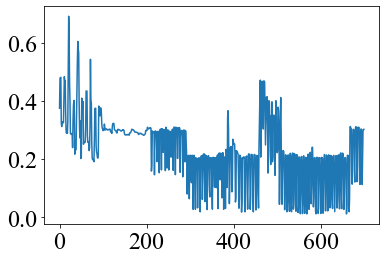

In [953]:
plt.plot(dataset_norm[:700, 0])

In [386]:
# Train deep learning model and fetch output
window_size = 10
n_window = dataset_norm.shape[0]-window_size+1
X, Y = [], []
for w in range(n_window-1):
    X.append(dataset_norm[w:w+window_size])
    Y.append(dataset[w+window_size, 0])
X, Y = np.asarray(X), np.asarray(Y)
print(X.shape, Y.shape)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, train_size=0.6, test_size=0.4, random_state=0, shuffle=True)
print(X_train.shape, X_test.shape)
print(Y_train.shape, Y_test.shape)
input_mlp = Input(shape=(X_train.shape[1:]))
H = Reshape((X_train.shape[1]*X_train.shape[2],))(input_mlp)
H = Dense(64, activation='tanh')(H)
H = Dense(64, activation='tanh')(H)
H = Dropout(0.5)(H)
H = Dense(32, activation='tanh')(H)
# H = Dropout(0.3)(H)
output_mlp = Dense(1, activation='linear')(H)
model_mlp = Model(input_mlp, output_mlp)
model_mlp.summary()
model_mlp.compile(loss='mse', optimizer='adam')
es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history_model_mlp = model_mlp.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=200, batch_size=4096, verbose=2, shuffle=True, callbacks=[es])
Y_test_hat = model_mlp.predict(X_test)

(2075249, 10, 8) (2075249,)
(1245149, 10, 8) (830100, 10, 8)
(1245149,) (830100,)
Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 10, 8)]           0         
_________________________________________________________________
reshape_9 (Reshape)          (None, 80)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 64)                5184      
_________________________________________________________________
dense_37 (Dense)             (None, 64)                4160      
_________________________________________________________________
dropout_11 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 32)                2080      
___________________________________________

In [578]:
pd.DataFrame(sig_hat).rolling(3).mean().values[:, 0][1]

nan

In [570]:
sig_hat.shape

(90, 1)

Font Changed: times new roman, 24


(0.44400000000000006, 3.9390000000000005)

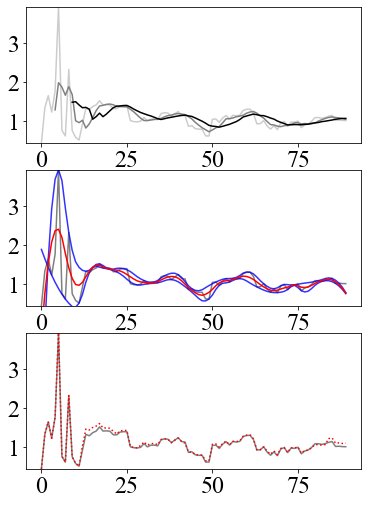

In [941]:
# Pyplot setting
sjbu_set_font(font_family='times new roman', font_size=24)
# Sample and visualization
sample_length = 90
rand_idx = np.random.randint(Y_test.shape[0]-sample_length)
sig, sig_hat = Y_test[rand_idx:rand_idx+sample_length], Y_test_hat[rand_idx:rand_idx+sample_length][:, 0]
# # For increasing
# sig += np.arange(0, sig.shape[0])*0.03
# sig_hat += np.arange(0, sig.shape[0])*0.03
# For decreasing
# sig += 3
# sig_hat += 3
# sig -= np.arange(0, sig.shape[0])*0.003
# sig_hat -= np.arange(0, sig_hat.shape[0])*0.003
# # For peak reveal
# sig_hat = pd.DataFrame(sig_hat).rolling(3).mean().values[:, 0]
# sig_hat[:2] = sig[:2]
# For Mean Reversion
sig_buffer = np.copy(sig)
sig = pd.DataFrame(sig).rolling(13).mean().values[:, 0]
sig[:12] = sig_buffer[:12]*1.5
sig_hat_buffer = np.copy(sig_buffer)
sig_hat = pd.DataFrame(sig_hat).rolling(13).mean().values[:, 0]
sig_hat[:12] = sig_hat_buffer[:12]*1.5

t = np.arange(0, sample_length)
# EMD setting
pks = signal.argrelmax(sig)[0]
sig_pks = sig[pks]
fip = sp.interpolate.InterpolatedUnivariateSpline(pks,sig_pks,k=2)
pks_t = fip(range(len(sig)))
trs = signal.argrelmin(sig)[0]
sig_trs = sig[trs]
fitr = sp.interpolate.InterpolatedUnivariateSpline(trs,sig_trs,k=2)
trs_t = fitr(range(len(sig)))
mean_t = (pks_t + trs_t) / 2
# Plot
plt.figure(figsize=(6,8.5))

plt.subplot(3,1,1)
plt.plot(t,sig,'k',label='Active Power', alpha=0.2)
sig_pd = pd.DataFrame(sig)
sig_ma5 = sig_pd.rolling(5).mean()
sig_ma10 = sig_pd.rolling(10).mean()
plt.plot(t, sig_ma5.values, 'gray', label='SMA5')
plt.plot(t, sig_ma10.values, 'k', label='SMA10')
# plt.xlabel('Time (m)')
# plt.ylabel('Kilowatt')
plt.ylim([np.min(sig), np.max(sig)])
# plt.legend(loc='best')
# plt.legend([])
plt.subplot(3,1,2)
plt.plot(t,sig,'k',label='Active Power', alpha=0.5)
plt.plot(t,pks_t,'b',label='Extrema Envelope', alpha=0.8)
plt.plot(t,trs_t,'b', alpha=0.8)
plt.plot(t,mean_t,'r',label='Mean of Extrema Envelopes')
# plt.ylabel('Kilowatt')
plt.ylim([np.min(sig), np.max(sig)])
# plt.legend(loc='best')
# plt.legend([])
plt.subplot(3,1,3)
plt.plot(t,sig,'k',label='Active Power', alpha=0.5)
plt.plot(t,sig_hat,c='r',label='Predicted', linestyle='dotted')
# plt.xlabel('Time (m)')
# plt.ylabel('Kilowatt')
plt.ylim([np.min(sig), np.max(sig)])
# plt.legend(loc='best')
# plt.legend([])

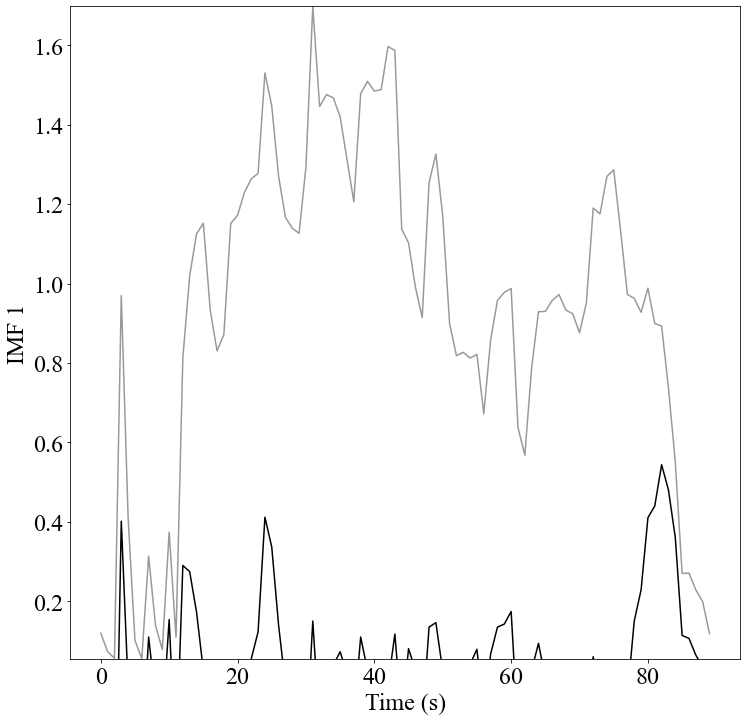

In [895]:
# Example Decomposition
imfs = emd(sig, nIMF=1)
plt.figure(figsize=(12,12))
for i in range(len(imfs)):
    plt.subplot(len(imfs),1,i+1)
    plt.plot(t, sig, color='0.6')
    plt.plot(t, imfs[i],'k')
    plt.ylim([np.min(sig), np.max(sig)])
    plt.ylabel('IMF '+np.str(i+1))
    if i == len(imfs)-1:
        plt.xlabel('Time (s)')